In [2]:
import os
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
import random
import pandas as pd
import multiprocessing as mp
import numpy as np
import osmnx as ox
import json
import networkx as nx
import pickle
from data_utils import *
import matplotlib

from scipy.stats import pearsonr
from scipy.stats import ttest_rel, ttest_ind
from scipy.stats import friedmanchisquare
from scipy.stats import shapiro
import matplotlib.pyplot as plt


## FUNCTION

In [12]:
def score_moyen_it(edges, column_score="total_score"):
    return edges[["id_it", column_score]].groupby("id_it", axis=0).mean()

## GLOBAL VARIABLES

In [13]:
tetedor_itineraries_path = "./output_data/studies_zones/tetedor/100_it.gpkg"
partdieu_itineraries_path = "./output_data/studies_zones/partdieu/partdieu_100_it.gpkg"
rillieux_itineraries_path = "./output_data/studies_zones/rillieux/rillieux_100_it.gpkg"

## TETE DOR 

In [14]:
tetedor_itineraries = gpd.read_file(tetedor_itineraries_path, layer="itineraries")

In [15]:
print(tetedor_itineraries.columns)

Index(['u', 'v', 'key', 'type', 'id_it', 'osmid', 'length', 'from', 'to',
       'score_distance', 'total_score', 'freshness_score',
       'score_distance_prop', 'exp_distance', 'exp_fresh_score',
       'exp_fresh_score_15', 'geometry'],
      dtype='object')


In [16]:
tetedor_itineraries_if = tetedor_itineraries[tetedor_itineraries["type"] == "IF"]
tetedor_itineraries_len = tetedor_itineraries[tetedor_itineraries["type"] == "LEN"]

In [17]:
score_tetedor_if = score_moyen_it(tetedor_itineraries_if)
score_tetedor_len = score_moyen_it(tetedor_itineraries_len)

In [28]:
tetedor_itineraries_if["total_score"]

0        8.370588
1        8.102588
2        7.910588
3        7.714588
4        7.626588
           ...   
10286    8.818588
10287    8.830000
10288    8.849647
10289    8.915647
10290    8.049294
Name: total_score, Length: 5273, dtype: float64

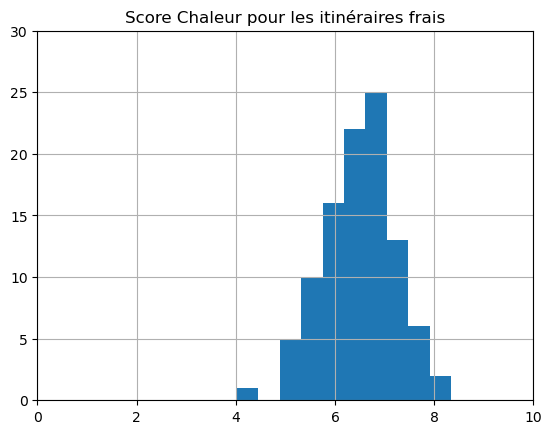

In [47]:
score_tetedor_if.hist()
plt.xlim([0,10])
plt.ylim([0,30])
plt.title("Score Chaleur pour les itinéraires frais")
plt.show()

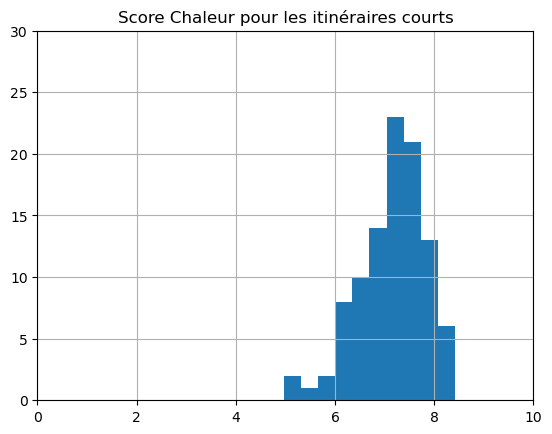

In [48]:
score_tetedor_len.hist()
plt.xlim([0,10])
plt.ylim([0,30])
plt.title("Score Chaleur pour les itinéraires courts")
plt.show()

<Axes: >

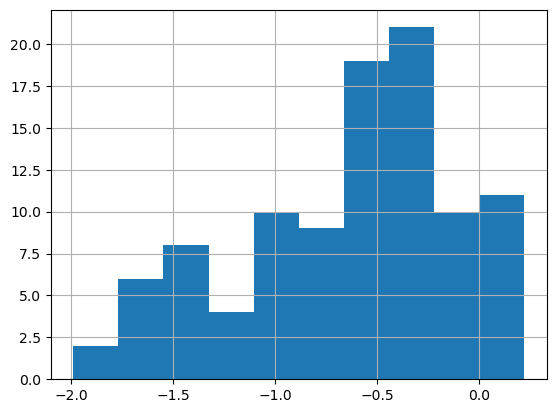

In [51]:
diff = score_tetedor_if["total_score"] - score_tetedor_len["total_score"]
diff.hist()

## T-test
Variance

In [33]:
print("var IF : ", score_tetedor_if["total_score"].var())
print("var LEN : ", score_tetedor_len["total_score"].var())

IF :  0.5400580571542966
LEN :  0.43208384617167805


Moyenne

In [34]:
print("mean IF : ", score_tetedor_if["total_score"].mean())
print("mean LEN : ", score_tetedor_len["total_score"].mean())

mean IF :  6.4956575026477195
mean LEN :  7.138552741124781


In [38]:
score_tetedor_if_values = score_tetedor_if["total_score"].values
score_tetedor_len_values = score_tetedor_len["total_score"].values

Test de Pearson : corrélation entre les deux variables

In [39]:
# Calculate the correlation coefficient and p-value
corr_coef, p_value = pearsonr(score_tetedor_if_values, score_tetedor_len_values)

# Print the correlation coefficient and p-value
print("Correlation coefficient:", corr_coef)
print("p-value:", p_value)

Correlation coefficient: 0.7213417811382976
p-value: 2.5654900457274465e-17


Coefficient de corrélation élevé => test de student non valide ? 
Logique qu'il soit élevé car pour les différents itinéraires, on prend en compte la distance ...

Ainsi, on réalise un test de student par paire avec des groupes dépendants. 
Par paire parce qu'on compare deux itinéraires qui ont les mêmes points de départs et d'arrivés. Donc on regarde deux mêmes itinéraires dont la différence est dûe à la présence de fraîcheur. 

Les hypothèses à respecter pour cela : 
https://datatab.fr/tutorial/paired-t-test

1) Dépendance des deux groupes
2) Variables échelonnées par intervalles (valeurs métriques)
3) Les différences entre les valeurs sont normalement distribuées => à confirmer)

Regardons dans un premier temps le test de normalité de la différence (test de shapiro), dans ce cas l'hypothèse nulle est la suivante : l'échantillon suit une loi normale. 

In [56]:
# Calculate the differences between the two variables
differences = score_tetedor_if["total_score"] - score_tetedor_len["total_score"]

# Perform the Shapiro-Wilk test
statistic, p_value = shapiro(differences)

# Print the test results
print("Test statistic:", statistic)
print("p-value:", p_value)

Test statistic: 0.9384604692459106
p-value: 0.0001554991613375023


Au regard de la p-value, on rejette H0, donc la différence entre les scores ne suit pas une loi normale. Donc normalement pas possible de réaliser un test de student par paire

Calcul du d de Cohen

In [57]:
# Extract the columns of interest as numpy arrays
scores_if = score_tetedor_if["total_score"].values
scores_len = score_tetedor_len["total_score"].values

# Calculate the means
mean1 = np.mean(scores_if)
mean2 = np.mean(scores_len)

# Calculate the pooled standard deviation
var1 = np.var(scores_if, ddof=1)
var2 = np.var(scores_len, ddof=1)
n1 = len(scores_if)
n2 = len(scores_len)
pooled_std = np.sqrt(((n1 - 1) * var1 + (n2 - 1) * var2) / (n1 + n2 - 2))

# Calculate the Cohen's d effect size
d = (mean1 - mean2) / pooled_std

# Print the effect size
print("Cohen's d effect size:", d)

Cohen's d effect size: -0.9221262291257983


Un d de cohen fort => une différence entre les deux. Mais ne permet que de valider ou infirmer les autres observations. Pas forcément validité statistique.

Test de Student
H0 : Se déplacer en fonction de la fraîcheur n'a pas d'effet sur le score de fraîcheur

In [53]:
t_statistic, p_value = ttest_rel(score_tetedor_if_values, score_tetedor_len_values)

# Afficher les résultats
print("Statistic de t :", t_statistic)
print("Valeur de p :", p_value)

Statistic de t : -12.25431626116627
Valeur de p : 1.4714450108579213e-21


Si Student valide On rejette H0 donc effet de la fraîcheur sur le score

Anova de Friedman : sur des échantillons avec dépendances entre eux, pas d'obligation de normalité. 
On teste l'hypothèse nulle H0 : les deux populations suivent la même loi.
Possible seulement avec 3 groupes. Par contre peut être utile pour comparer différents contextes

In [77]:
#friedman_statistic, friedman_p_value = friedmanchisquare(score_tetedor_if_values, score_tetedor_len_values)
#print("Friedman Statistic : ", friedman_statistic)
#print("Friedman p-value : ", friedman_p_value)

## Score * distance

In [18]:
score_distance_tetedor_if = score_moyen_it(tetedor_itineraries_if, "score_distance")
score_distance_tetedor_len = score_moyen_it(tetedor_itineraries_len, "score_distance")

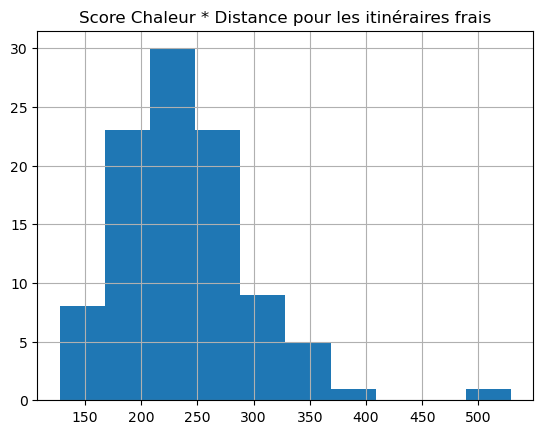

In [23]:
score_distance_tetedor_if.hist()
#plt.xlim([0,10])
#plt.ylim([0,30])
plt.title("Score Chaleur * Distance pour les itinéraires frais")
plt.show()

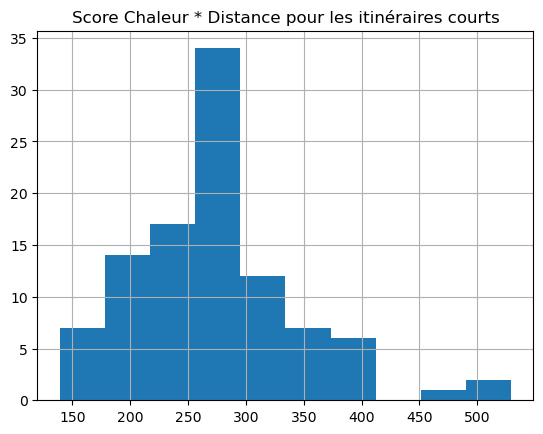

In [22]:
score_distance_tetedor_len.hist()
#plt.xlim([0,10])
#plt.ylim([0,30])
plt.title("Score Chaleur * Distance pour les itinéraires courts")
plt.show()

# PART DIEU

In [60]:
partdieu_itineraries = gpd.read_file(partdieu_itineraries_path, layer="itineraries")

In [62]:
partdieu_itineraries_if = partdieu_itineraries[partdieu_itineraries["type"] == "IF"]
partdieu_itineraries_len = partdieu_itineraries[partdieu_itineraries["type"] == "LEN"]

In [63]:
score_partdieu_if = score_moyen_it(partdieu_itineraries_if)
score_partdieu_len = score_moyen_it(partdieu_itineraries_len)

In [64]:
partdieu_itineraries_if["total_score"]

0       4.903529
1       4.934118
2       5.580000
3       8.209412
4       8.132353
          ...   
6839    8.822353
6840    8.822353
6841    8.822353
6842    8.816353
6843    8.650353
Name: total_score, Length: 3524, dtype: float64

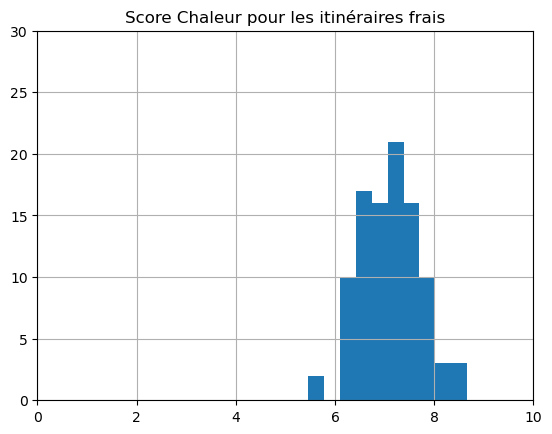

In [65]:
score_partdieu_if.hist()
plt.xlim([0,10])
plt.ylim([0,30])
plt.title("Score Chaleur pour les itinéraires frais")
plt.show()

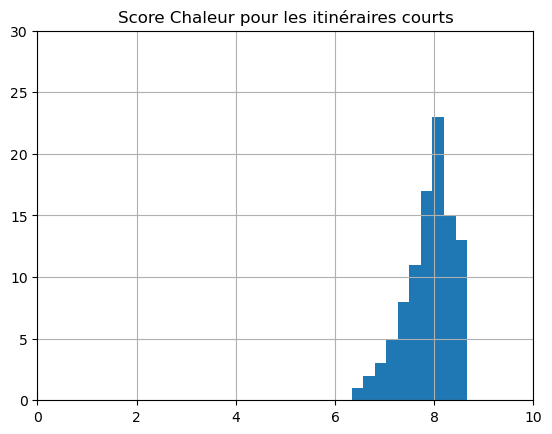

In [66]:
score_partdieu_len.hist()
plt.xlim([0,10])
plt.ylim([0,30])
plt.title("Score Chaleur pour les itinéraires courts")
plt.show()

In [68]:
print("var IF : ", score_partdieu_if["total_score"].var())
print("var LEN : ", score_partdieu_len["total_score"].var())

var IF :  0.387674455627185
var LEN :  0.23369292091311092


Moyenne

In [67]:
print("mean IF : ", score_partdieu_if["total_score"].mean())
print("mean LEN : ", score_partdieu_len["total_score"].mean())

mean IF :  7.129759255937062
mean LEN :  7.894766231198389


In [69]:
score_partdieu_if_values = score_partdieu_if["total_score"].values
score_partdieu_len_values = score_partdieu_len["total_score"].values

Test de Pearson : corrélation entre les deux variables

In [70]:
# Calculate the correlation coefficient and p-value
corr_coef, p_value = pearsonr(score_partdieu_if_values, score_partdieu_len_values)

# Print the correlation coefficient and p-value
print("Correlation coefficient:", corr_coef)
print("p-value:", p_value)

Correlation coefficient: 0.3827263351743969
p-value: 0.00010051099517223542


Avec ce coefficient de corrélation, on pourrait presque dire que les variables ne sont pas corrélées donc indépendantes. Donc un test de student normal pourrait faire l'affaire. Cela étant dit, il ne paraît pas abbérant de réaliser un test de student par paire car on est dans la même configuration que précédemment. C'est à dire qu'on regarde le même couple "départ" "arrivée" et on regarde la différence après le "traitement" par le poids de fraîcheur / chaleur 

In [71]:
# Calculate the differences between the two variables
differences = score_partdieu_if["total_score"] - score_partdieu_len["total_score"]

# Perform the Shapiro-Wilk test
statistic, p_value = shapiro(differences)

# Print the test results
print("Test statistic:", statistic)
print("p-value:", p_value)

Test statistic: 0.931958794593811
p-value: 7.618096424266696e-05


Les distributions ne suivent toujours pas de lois normales donc on ne peut pas réaliser de test de student par paire à priori.

In [72]:
# Extract the columns of interest as numpy arrays
scores_if = score_partdieu_if["total_score"].values
scores_len = score_partdieu_len["total_score"].values

# Calculate the means
mean1 = np.mean(scores_if)
mean2 = np.mean(scores_len)

# Calculate the pooled standard deviation
var1 = np.var(scores_if, ddof=1)
var2 = np.var(scores_len, ddof=1)
n1 = len(scores_if)
n2 = len(scores_len)
pooled_std = np.sqrt(((n1 - 1) * var1 + (n2 - 1) * var2) / (n1 + n2 - 2))

# Calculate the Cohen's d effect size
d = (mean1 - mean2) / pooled_std

# Print the effect size
print("Cohen's d effect size:", d)

Cohen's d effect size: -1.3724804562032922


In [74]:
t_statistic, p_value = ttest_ind(score_partdieu_if_values, score_partdieu_len_values)

# Afficher les résultats
print("Statistic de t :", t_statistic)
print("Valeur de p :", p_value)

Statistic de t : -9.607363193423048
Valeur de p : 4.014526360179411e-18


Si on considère indépendance des variables, alors on rejette H0 (les deux itinéraires ont la même moyenne de score de fraîcheur). 

# Rillieux

In [7]:
rillieux_itineraries = gpd.read_file(rillieux_itineraries_path, layer="itineraries")

In [8]:
rillieux_itineraries_if = rillieux_itineraries[rillieux_itineraries["type"] == "IF"]
rillieux_itineraries_len = rillieux_itineraries[rillieux_itineraries["type"] == "LEN"]

# Analyse de la fréquence

Par zone, pour chaque segment, analyse de la fréquence de passage par tel ou tel segment en fonction du type d'itinéraire.

## TETE D'OR

In [141]:
freq_edges_if_tetedor = gpd.GeoDataFrame({
    "count": tetedor_itineraries_if.groupby(["u", "v", "key"])["total_score"].count(),
    "score": tetedor_itineraries_if.groupby(["u", "v", "key"])["total_score"].apply(lambda x: round(x.unique()[0])),
    "geometry": tetedor_itineraries_if.groupby(["u", "v", "key"])["geometry"].apply(lambda x: x.unique()[0])
})

#freq_edges_if_tetedor.to_file("./output_data/studies_zones/tetedor/count_freq_if_tetedor.gpkg", driver="GPKG", layer="edges")

In [143]:
freq_edges_len_tetedor = gpd.GeoDataFrame({
    "count": tetedor_itineraries_len.groupby(["u", "v", "key"])["total_score"].count(),
    "score": tetedor_itineraries_len.groupby(["u", "v", "key"])["total_score"].apply(lambda x: round(x.unique()[0])),
    "geometry": tetedor_itineraries_len.groupby(["u", "v", "key"])["geometry"].apply(lambda x: x.unique()[0])
})

#freq_edges_len_tetedor.to_file("./output_data/studies_zones/tetedor/count_freq_len_tetedor.gpkg", driver="GPKG", layer="edges")

/tmp/ipykernel_15993/600788375.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_blues_reversed = matplotlib.cm.get_cmap('Blues')


<Axes: >

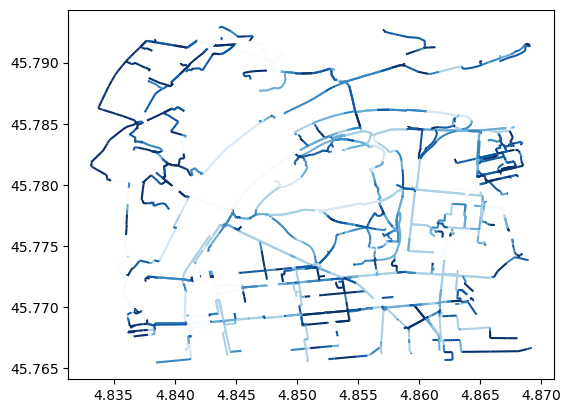

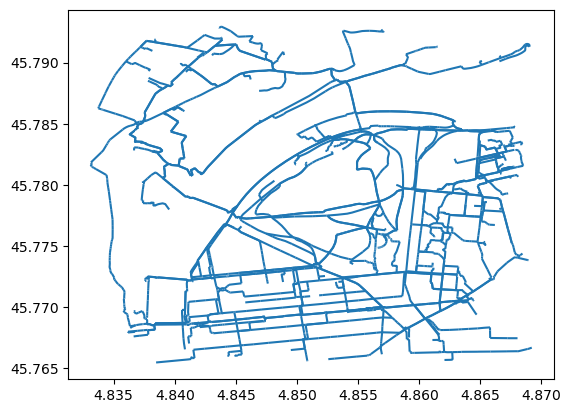

In [151]:
cmap_blues_reversed = matplotlib.cm.get_cmap('Blues')
freq_edges_if_tetedor.plot(column="score", cmap=cmap_blues_reversed)
freq_edges_len_tetedor.plot()

## PART DIEU

In [152]:
freq_edges_if_partdieu = gpd.GeoDataFrame({
    "count": partdieu_itineraries_if.groupby(["u", "v", "key"])["total_score"].count(),
    "score": partdieu_itineraries_if.groupby(["u", "v", "key"])["total_score"].apply(lambda x: round(x.unique()[0])),
    "geometry": partdieu_itineraries_if.groupby(["u", "v", "key"])["geometry"].apply(lambda x: x.unique()[0])
})

freq_edges_if_partdieu.to_file("./output_data/studies_zones/partdieu/count_freq_if_partdieu.gpkg", driver="GPKG", layer="edges")

In [153]:
freq_edges_len_partdieu = gpd.GeoDataFrame({
    "count": partdieu_itineraries_len.groupby(["u", "v", "key"])["total_score"].count(),
    "score": partdieu_itineraries_len.groupby(["u", "v", "key"])["total_score"].apply(lambda x: round(x.unique()[0])),
    "geometry": partdieu_itineraries_len.groupby(["u", "v", "key"])["geometry"].apply(lambda x: x.unique()[0])
})

freq_edges_len_partdieu.to_file("./output_data/studies_zones/partdieu/count_freq_len_partdieu.gpkg", driver="GPKG", layer="edges")

## RILLIEUX

In [9]:
freq_edges_if_rillieux = gpd.GeoDataFrame({
    "count": rillieux_itineraries_if.groupby(["u", "v", "key"])["total_score"].count(),
    "score": rillieux_itineraries_if.groupby(["u", "v", "key"])["total_score"].apply(lambda x: round(x.unique()[0])),
    "geometry": rillieux_itineraries_if.groupby(["u", "v", "key"])["geometry"].apply(lambda x: x.unique()[0])
})

freq_edges_if_rillieux.to_file("./output_data/studies_zones/rillieux/count_freq_if_rillieux.gpkg", driver="GPKG", layer="edges")

In [10]:
freq_edges_len_rillieux = gpd.GeoDataFrame({
    "count": rillieux_itineraries_len.groupby(["u", "v", "key"])["total_score"].count(),
    "score": rillieux_itineraries_len.groupby(["u", "v", "key"])["total_score"].apply(lambda x: round(x.unique()[0])),
    "geometry": rillieux_itineraries_len.groupby(["u", "v", "key"])["geometry"].apply(lambda x: x.unique()[0])
})

freq_edges_len_rillieux.to_file("./output_data/studies_zones/rillieux/count_freq_len_rillieux.gpkg", driver="GPKG", layer="edges")